In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from galvani import BioLogic

In [21]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## read files (csv)

In [22]:
path = '20230217_EIS_Temp_SoC'

In [23]:
# pkl_files = [path+'/'+pkl for pkl in os.listdir(path) if pkl.endswith('.pkl')]
csv_files = [path+'/'+pkl for pkl in os.listdir(path) if pkl.endswith('.csv')]
dfs = []
for file in csv_files:
    dfs.append(pd.read_csv(file))
    
# concat all dfs
df = pd.concat(dfs).reset_index()

In [24]:
df

,index,Unnamed: 0,0,cycle_Nr,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,...,Re(Z)3061.0,-Im(Z)3061.0,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0,I(uA),SoH/%
0,0,0,NaN,1.0,48852.200,46573.100,39784.600,41140.600,41164.000,38890.600,...,1052.980,1524.2000,780.681,1205.8100,576.129,936.6760,20.1169,672.4060,20.0,157.97
1,1,1,NaN,2.0,4262.660,744.727,4109.630,680.813,3915.340,646.593,...,539.758,373.8830,440.624,342.6310,352.459,305.1430,281.6410,268.2390,20.0,174.81
2,2,2,NaN,3.0,1475.700,466.609,1343.660,418.363,1274.420,371.091,...,197.916,72.8279,178.468,73.8025,157.575,72.0772,133.8640,68.9481,20.0,178.65
3,3,3,NaN,4.0,903.619,321.803,836.947,268.775,776.234,249.611,...,133.406,47.5855,120.451,46.9005,107.645,44.2770,94.0251,41.8847,20.0,160.39
4,4,4,NaN,5.0,860.372,306.783,787.428,257.149,740.479,232.201,...,133.995,50.1709,120.529,48.6607,107.826,45.6482,95.3007,40.9052,20.0,145.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,40,3,NaN,33.0,5693.940,3067.950,5140.950,2769.710,4593.950,2198.980,...,235.832,118.9060,209.012,109.1910,182.877,100.3820,173.1570,92.1590,500.0,59.13
721,41,4,NaN,43.0,6531.200,3458.990,5688.250,2961.940,5184.170,2684.440,...,236.618,123.4520,208.045,112.9360,181.902,102.5530,151.2850,77.2161,500.0,58.89
722,42,5,NaN,53.0,7164.470,3937.410,6437.400,3329.740,5622.280,3001.000,...,238.036,126.9360,208.906,115.8840,182.274,105.6630,163.5280,113.2910,500.0,55.33
723,43,6,NaN,63.0,8034.780,4295.500,7237.330,3797.210,6472.130,3184.560,...,260.844,144.9180,226.336,132.5000,195.831,120.8760,155.3430,127.3620,500.0,54.69


### remove unnecessary columns

In [25]:
df = df.drop([df.columns[0], df.columns[1], df.columns[2], df.columns[-1], df.columns[-2]], axis=1)

In [26]:
df

,cycle_Nr,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,Re(Z)0.0325963,-Im(Z)0.0325963,Re(Z)0.0488944,...,Re(Z)2063.0,-Im(Z)2063.0,Re(Z)3061.0,-Im(Z)3061.0,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0
0,1.0,48852.200,46573.100,39784.600,41140.600,41164.000,38890.600,38284.100,33659.900,36293.000,...,1414.240,1897.7100,1052.980,1524.2000,780.681,1205.8100,576.129,936.6760,20.1169,672.4060
1,2.0,4262.660,744.727,4109.630,680.813,3915.340,646.593,3753.190,610.109,3632.000,...,645.912,397.2940,539.758,373.8830,440.624,342.6310,352.459,305.1430,281.6410,268.2390
2,3.0,1475.700,466.609,1343.660,418.363,1274.420,371.091,1175.120,330.920,1100.940,...,215.901,70.6000,197.916,72.8279,178.468,73.8025,157.575,72.0772,133.8640,68.9481
3,4.0,903.619,321.803,836.947,268.775,776.234,249.611,724.889,213.158,679.224,...,147.119,47.9426,133.406,47.5855,120.451,46.9005,107.645,44.2770,94.0251,41.8847
4,5.0,860.372,306.783,787.428,257.149,740.479,232.201,687.780,198.357,644.641,...,148.507,51.3697,133.995,50.1709,120.529,48.6607,107.826,45.6482,95.3007,40.9052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,33.0,5693.940,3067.950,5140.950,2769.710,4593.950,2198.980,4061.140,1923.950,3659.270,...,265.572,129.0600,235.832,118.9060,209.012,109.1910,182.877,100.3820,173.1570,92.1590
721,43.0,6531.200,3458.990,5688.250,2961.940,5184.170,2684.440,4527.470,2220.170,4052.490,...,267.041,135.0610,236.618,123.4520,208.045,112.9360,181.902,102.5530,151.2850,77.2161
722,53.0,7164.470,3937.410,6437.400,3329.740,5622.280,3001.000,5007.440,2501.720,4490.050,...,270.286,139.6600,238.036,126.9360,208.906,115.8840,182.274,105.6630,163.5280,113.2910
723,63.0,8034.780,4295.500,7237.330,3797.210,6472.130,3184.560,5723.720,2846.980,5118.440,...,297.298,158.0460,260.844,144.9180,226.336,132.5000,195.831,120.8760,155.3430,127.3620


## split dfs

In [27]:
# df

abnormal_cycle = 3

df_normal = df[df['cycle_Nr'] > abnormal_cycle].drop('cycle_Nr', axis=1)
df_abnormal = df[df['cycle_Nr'] <= abnormal_cycle].drop('cycle_Nr', axis=1)

# log df
df_t = np.log(df.drop('cycle_Nr', axis=1))
df_t_normal = np.log(df_normal)
df_t_abnormal = np.log(df_abnormal)

#Im(Z) and Re(Z)
df_re = df[df.columns.drop(list(df_normal.filter(regex='Im')))]
df_im = df[df.columns.drop(list(df_normal.filter(regex='Re')))]
df_t_re = np.log(df_re)
df_t_im = np.log(df_im)

# Im(Z) normal/abnormal
df_im_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Re')))]
df_im_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Re')))]
df_im_t_normal = np.log(df_im_normal)
df_im_t_abnormal = np.log(df_im_abnormal)

# Re(Z) normal/abnormal
df_re_normal = df_normal[df_normal.columns.drop(list(df_normal.filter(regex='Im')))]
df_re_abnormal = df_abnormal[df_abnormal.columns.drop(list(df_abnormal.filter(regex='Im')))]
df_re_t_normal = np.log(df_re_normal)
df_re_t_abnormal = np.log(df_re_abnormal)

In [28]:
df_t_normal

,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,Re(Z)0.0325963,-Im(Z)0.0325963,Re(Z)0.0488944,-Im(Z)0.0488944,...,Re(Z)2063.0,-Im(Z)2063.0,Re(Z)3061.0,-Im(Z)3061.0,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0
3,6.806408,5.773940,6.729761,5.593875,6.654454,5.519904,6.586019,5.362034,6.520951,5.253974,...,4.991242,3.870004,4.893397,3.862528,4.791243,3.848028,4.678839,3.790465,4.543562,3.734921
4,6.757365,5.726141,6.668772,5.549656,6.607297,5.447603,6.533469,5.290068,6.468694,5.172754,...,5.000632,3.939049,4.897802,3.915435,4.791890,3.884872,4.680519,3.820964,4.557037,3.711257
5,6.806975,5.743163,6.739785,5.643459,6.673225,5.448167,6.603078,5.345716,6.537936,5.237888,...,5.082944,4.087075,4.980066,4.058588,4.869824,4.007808,4.759461,3.917156,4.652884,3.844795
6,6.913200,5.818390,6.834219,5.684399,6.783347,5.569897,6.703375,5.425285,6.646892,5.309613,...,5.188491,4.241711,5.079104,4.196375,4.960997,4.124405,4.848171,4.033495,4.729562,3.920731
7,6.992188,5.910092,6.922269,5.724826,6.853701,5.645157,6.791125,5.484859,6.731115,5.372757,...,5.263814,4.337286,5.148854,4.283054,5.034046,4.212751,4.917708,4.129927,4.793913,4.061093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,8.647158,8.028765,8.544993,7.926498,8.432495,7.695749,8.309219,7.562136,8.205019,7.420459,...,5.581886,4.860277,5.463120,4.778333,5.342392,4.693099,5.208814,4.608983,5.154199,4.523515
721,8.784346,8.148732,8.646158,7.993600,8.553365,7.895227,8.417919,7.705339,8.307087,7.553926,...,5.587402,4.905727,5.466447,4.815852,5.337754,4.726821,5.203468,4.630380,5.019165,4.346608
722,8.876889,8.278278,8.769880,8.110650,8.634493,8.006701,8.518680,7.824734,8.409619,7.685437,...,5.599481,4.939211,5.472422,4.843683,5.341884,4.752590,5.205511,4.660255,5.096984,4.729960
723,8.991535,8.365323,8.887008,8.242022,8.775261,8.066069,8.652374,7.954014,8.540605,7.820921,...,5.694735,5.062886,5.563923,4.976168,5.422021,4.886583,5.277252,4.794765,5.045636,4.847033


<IPython.core.display.Javascript object>


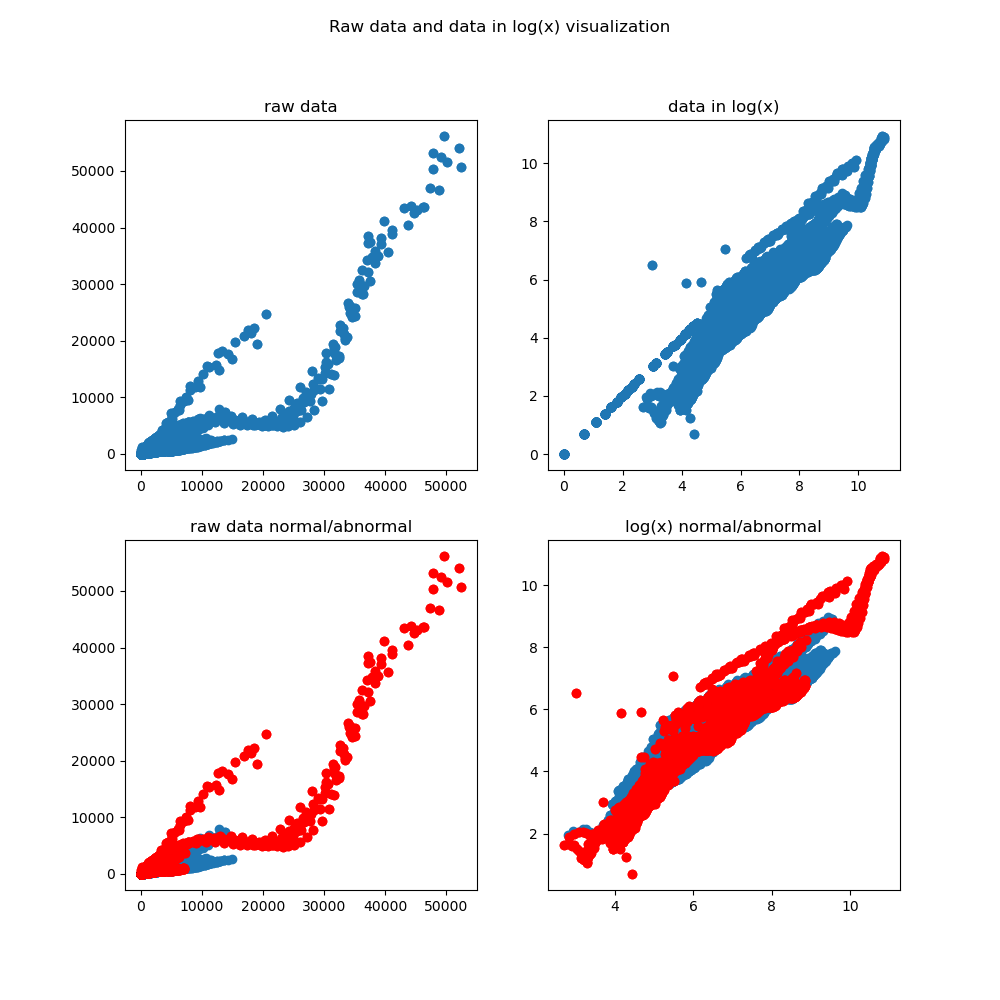

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Raw data and data in log(x) visualization')

axes[0][0].set_title('raw data')
axes[0][0].scatter(df_re, df_im)

axes[0][1].set_title('data in log(x)')
axes[0][1].scatter(df_t_re, df_t_im)

axes[1][0].set_title('raw data normal/abnormal')
axes[1][0].scatter(df_re_normal, df_im_normal)
axes[1][0].scatter(df_re_abnormal, df_im_abnormal, c='r')

axes[1][1].set_title('log(x) normal/abnormal')
axes[1][1].scatter(df_re_t_normal, df_im_t_normal)
axes[1][1].scatter(df_re_t_abnormal, df_im_t_abnormal, c='r')

plt.show()

<IPython.core.display.Javascript object>


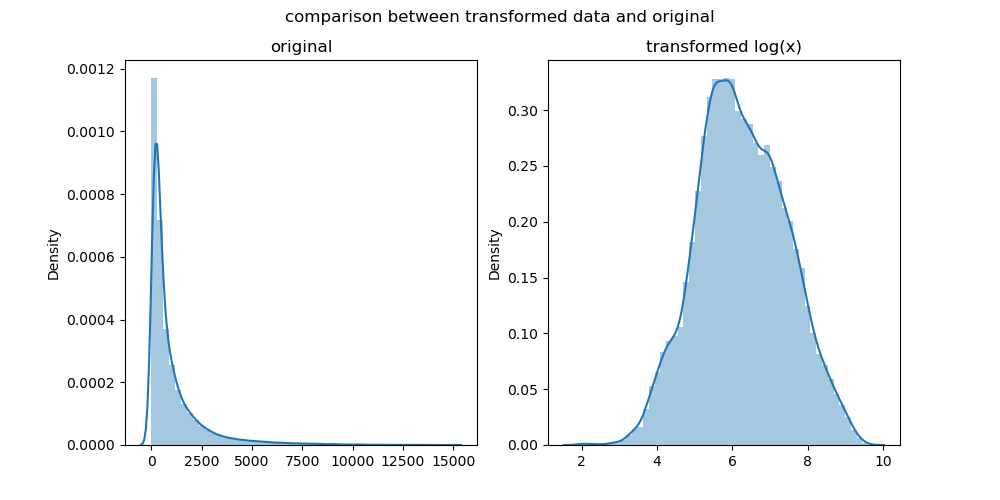

C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\azhar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [30]:
# more gaussian

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('comparison between transformed data and original')

axes[0].set_title('original')
sns.distplot(df_normal, ax=axes[0])

axes[1].set_title('transformed log(x)')
sns.distplot(df_t_normal, ax=axes[1])

plt.show()

## Training

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
good_samples_train, good_samples_crv, good_samples_test = np.split(df_t_normal.sample(frac=1, random_state=42), 
                                                            [int(.6*len(df_t_normal)), int(.8*len(df_t_normal))])

abnormal_samples_crv, abnormal_samples_test = train_test_split(df_t_abnormal, test_size=0.5)


print('good samples: \n  train: {}\n  crv:    {}\n  test:  {}'.format(good_samples_train.shape, 
                                                                     good_samples_crv.shape, 
                                                                     good_samples_test.shape))
print('\nabnormal samples: \n crv: {} \n test: {}'.format(abnormal_samples_crv.shape, abnormal_samples_test.shape))

good samples: 
  train: (358, 72)
  crv:    (119, 72)
  test:  (120, 72)

abnormal samples: 
 crv: (64, 72) 
 test: (64, 72)


In [33]:
# probability using multivariate normal probability distribution function

def probability(df, colname='P(X)'):
    # mean, covariance matrix
    mean = df.mean()
    cov_matrix = np.diag(np.std(df))
    
    from scipy.stats import multivariate_normal
    var = multivariate_normal.pdf(np.array(df), mean=mean, cov=cov_matrix)
    
    # return probability
    return pd.DataFrame(var, columns=[colname])

In [34]:
good_p = probability(good_samples_train)

In [35]:
good_p

,P(X)
0,6.255259e-27
1,1.327403e-27
2,4.409893e-27
3,1.163054e-25
4,2.738222e-55
...,...
353,1.113271e-30
354,3.334622e-26
355,6.031461e-38
356,2.616436e-37


In [36]:
# label of normal/abnormal, normal = 0, abnormal = 1 based on abnormal cycle number above

label_good = pd.DataFrame(0, index=good_samples_crv.index, columns=['normal/abnormal'])
label_abnormal = pd.DataFrame(1, index=abnormal_samples_crv.index, columns=['normal/abnormal'])
print('abnormal samples shape: {}\nnormal samples shape: {}'.format(abnormal_samples_crv.shape, good_samples_crv.shape))

# combine the two
dfs = [abnormal_samples_crv, good_samples_crv]
labels = [label_abnormal, label_good]
crv = pd.concat(dfs)
crv_label = pd.concat(labels)

# random num to randomize the index (applies to both label and samples)
idx = np.random.permutation(crv.index)
crv = crv.loc[idx]
crv_label = crv_label.loc[idx]

# cross validation probability
crv_p = probability(crv, 'P2(X)')
crv_label = np.array(crv_label)
crv['normal/abnormal'] = crv_label
crv = crv[['normal/abnormal']+list(crv.columns.drop('normal/abnormal'))]


print('cross validation shape: {}'.format(crv_p.shape))

abnormal samples shape: (64, 72)
normal samples shape: (119, 72)
cross validation shape: (183, 1)


In [37]:
crv_p

,P2(X)
0,1.831767e-31
1,5.846444e-38
2,1.041811e-136
3,1.959122e-39
4,2.958177e-32
...,...
178,1.048219e-37
179,9.375337e-32
180,5.460692e-32
181,1.280645e-40


# find epsilon

In [38]:
# function to calculate true positives, false positives, and false negatives

def tpfpfn(ep, p):
    tp, fp, fn = 0, 0, 0
    for i in range(len(crv_label)):
        if p[i] <= ep and crv_label[i][0] == 1:
            tp += 1
        elif p[i] <= ep and crv_label[i][0] == 0:
            fp += 1
        elif p[i] > ep and crv_label[i][0] == 1:
            fn += 1
    return tp, fp, fn

# function calculate f1 score

def f1(ep, p):
    try:
        tp, fp, fn = tpfpfn(ep, p)
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        f1 = 2*prec*rec/(prec + rec)
    except ZeroDivisionError:
        f1 = 0
    return f1

# returns a list of labels where anomaly = 1 and 0 otherwise
def detect_anomaly(df, ep):
    # test probability
    # label each with 1 if probability is smaller than epsilon
    df_t = df
    df_p = np.array(probability(df))
    label = []
    for i in range(len(df_t)):
        if np.array(df_p)[i] <= ep:
            label.append(1)
        else:
            label.append(0)
    return label

# plot
def graph_anom(df_anomaly):
    df_im_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 1]
    df_im_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Re')))].loc[df_anomaly['label'] == 0]
    df_re_anomaly = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 1]
    df_re_good = df_anomaly[df_anomaly.columns.drop(list(df_anomaly.filter(regex='Im')))].loc[df_anomaly['label'] == 0]
    
    plt.title("Anomalies")
    
    plt.scatter(df_re_anomaly, df_im_anomaly, c='red', label='anomaly') # re and -im
    plt.scatter(df_re_good, df_im_good, label='good')
    plt.xlabel('Re')
    plt.ylabel('-Im')
    plt.legend()
    plt.show()

In [39]:
# epsilon

# current selected threshold is the mean of cross validation probability
threshold = crv_p.mean()[0]

epsilon = []
for i in np.array(crv_p):
    ep = i[0]
    if ep <= threshold and ep != 0:
        epsilon.append(ep)

# find the f1 score for each epsilon and probability

f = []
for i in epsilon:
    f.append(f1(i, np.array(crv_p)))
    
# epsilon variable to use for all anomaly measurement
e = epsilon[np.array(f).argmax()]
print('epsilon: {}'.format(e))

epsilon: 1.3906783985333693e-32


## Result

<IPython.core.display.Javascript object>


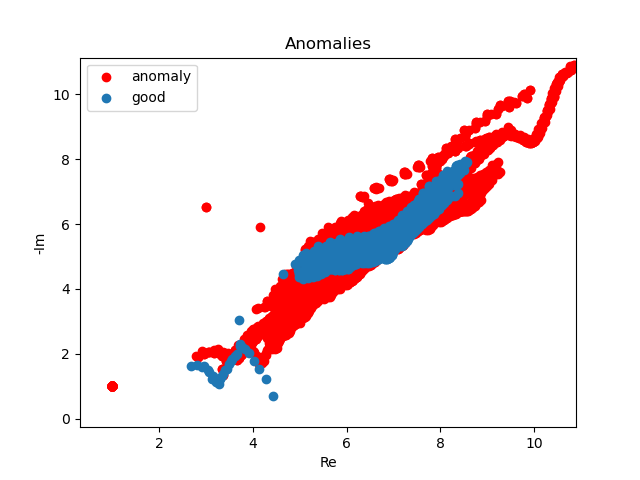

In [40]:
# anomaly detection with test data

dfs_test = [abnormal_samples_test, good_samples_test]
df_test = pd.concat(dfs_test)

# parameter: test dataframe and epsilon
df_test['label'] = detect_anomaly(df_test, e)
graph_anom(df_test)

In [123]:
df_test

,Re(Z)0.00931323,-Im(Z)0.00931323,Re(Z)0.0139698,-Im(Z)0.0139698,Re(Z)0.0209548,-Im(Z)0.0209548,Re(Z)0.0325963,-Im(Z)0.0325963,Re(Z)0.0488944,-Im(Z)0.0488944,...,-Im(Z)2063.0,Re(Z)3061.0,-Im(Z)3061.0,Re(Z)4542.0,-Im(Z)4542.0,Re(Z)6740.0,-Im(Z)6740.0,Re(Z)10001.0,-Im(Z)10001.0,label
247,7.126111,5.984007,7.045881,5.868361,6.993116,5.794342,6.910521,5.670932,6.838762,5.571279,...,4.042084,5.131773,4.071306,5.031372,4.105756,4.916383,4.117517,4.760566,4.081146,1
705,6.018542,4.853545,6.072143,4.815893,5.989575,4.948008,5.887936,4.782144,5.838048,4.647348,...,3.203965,4.533738,3.189072,4.471351,3.171428,4.406139,3.146615,4.330731,3.057086,1
590,5.776438,5.402227,5.501009,4.704545,5.666351,4.277241,5.663113,4.309034,5.574383,4.154557,...,2.510615,4.424294,2.508257,4.387207,2.486597,4.350015,2.483923,4.345941,3.096762,1
565,5.339853,5.009682,5.260911,4.009611,5.426394,3.957010,5.372928,4.117514,5.287267,3.934252,...,2.590737,4.222798,2.692612,4.168389,2.768028,4.086875,2.837744,4.008211,2.757190,1
265,7.833893,6.539570,7.760275,6.447143,7.714749,6.331142,7.643056,6.231577,7.582596,6.149244,...,5.142984,5.712858,5.125962,5.543199,5.079875,5.357492,5.001635,5.135381,4.914190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,9.096678,7.813470,9.037808,7.659068,8.969851,7.597497,8.912767,7.500706,8.850420,7.427572,...,5.968101,6.218433,5.875178,6.031005,5.766926,5.830817,5.644064,5.559897,5.518793,1
127,8.185322,6.875843,8.115192,6.725138,8.063302,6.665428,8.003350,6.545646,7.946625,6.467495,...,5.376481,5.877663,5.310093,5.723647,5.237920,5.557492,5.151955,5.373490,5.083359,0
339,7.529852,6.298688,7.480490,6.177151,7.422864,6.016789,7.363083,5.947102,7.305067,5.855086,...,4.984750,5.492180,4.964298,5.316339,4.907391,5.118425,4.820314,4.916808,4.716211,1
539,8.011912,6.648057,7.950361,6.615540,7.895455,6.477628,7.826918,6.419060,7.765374,6.343211,...,5.172306,6.194073,5.120595,6.103569,5.068281,6.011262,5.010068,5.908721,4.972075,0
